# Portfolio Optimization

- Based on modern portfolio theory, this optimization technique attempts to maximize the Sharpe ratio by achieving the maximum return per unit of risk incurred as measured in stock volatility. There are two types of risk associated with a stock, one being systematic risk that is inherent with the market as a whole and another being unsystematic risk or company specific risk which can be potentially mitigated through diversification. The portfolio theory utilizes this intuition and attempts to mitigate the unsystematic risk by combining different positions that are not correlated with one another.

### - Note: The stocks and process used in this demonstration are in no way financial advice. Additionally there is no guarantee of accuracy related to the data imported from the yfinance package.

### Import Required Packages 

In [82]:
import pandas as pd
import numpy as np
import statistics as stat
from matplotlib import pyplot as plt

import pyfolio as pf
import yfinance as yf
from itertools import combinations

import warnings
warnings.filterwarnings("ignore")

### Portfolio Optimization

In [83]:
# List the stock tickers in a porfolio to be analyzed
# The stock selection below is just for demonstation and should not be considered as advise
stock_list = ['AAPL', 'NKE', 'WMT', 'META']

# Find the size of the portfolio, save as a variable
portfolio_count = len(stock_list)

### Variance and Standard Deviation

In [84]:
# Create empty lists to store tha values generated within the for loop
return_list = []
annual_return_list = []
std_dev_list = []
annual_std_list = []


# For every stock in the stock portfolio
for i in range(0,portfolio_count,1):
    # Import stock data
    stock_name = stock_list[i]
    ticker = yf.Ticker(stock_name)
    history_info = ticker.history(period = '100mo')
    history_info['daily_returns'] = history_info['Close'].pct_change()
    history_info = history_info.iloc[1:]
    
    # Obtain returns
    returns = history_info['daily_returns'].values

    # Find total Return
    total_return = sum(returns)

    # Average Return
    avg_return = total_return / (len(returns) - 1)

    # Average Annual Return
    Avg_annual_return = avg_return * 12
    
    annual_return_list.append(Avg_annual_return)
    return_list.append(returns)
    
    
    # Variance
    variance = stat.variance(returns)

    # Standard Deviation
    st_dev = np.sqrt(variance)

    # Annual Standard Deviation
    annual_st_dev = st_dev * 12
    
    std_dev_list.append(st_dev)
    annual_std_list.append(annual_st_dev)

### Covariance

In [85]:
# Create an empty dataframe to store the return matrix
return_df = pd.DataFrame()

i = 0
for stock in stock_list:
    return_df[stock] = return_list[i]
    i = i + 1
    
    
# Calculate the covariance
covariance_df = return_df.cov()
covariance_df


# Discover the number of possible combinations for the specified portfolio
num_list = []
for i in range(0,portfolio_count,1):
    num_list.append(i)
iter_combos = list(combinations(num_list, 2))

# Generate the possible combinations
combos = []
for combo in iter_combos:
    z = list(combo)
    combos.append(z)
    
# Generate a list that specifies the covariance for each combination discovered
cov_list = []
for c in combos:
    cov_list.append(covariance_df.iloc[c[0],c[1]])

### Portfolio Weight Simulation

In [86]:
# Specify the number of simulated portfolios to test and set random seed
np.random.seed(seed=42)
num_portfolios = 1000000

# Establish empty lists to store generated values
portfolio_return = []
portfolio_dev = []
weight_history = []

for i in range (0,num_portfolios,1):
    # Genrate random weights for each portfolio combination tested
    weights = np.array(np.random.random(portfolio_count))
    
    # Normalize the weights to total 100%
    weights = weights / np.sum(weights)
    weight_history.append(weights)
    
    # Expected Return
    # Initialize the expected return variable
    exp_return = 0
    for i in range(0, portfolio_count,1):
        # Calculate the total expected return for all of the stocks and their weights
        incremental_return = ((weights[i] * annual_return_list[i]))
        # Combine all of the stocks expected returns
        exp_return = exp_return + incremental_return
    
    
    # Portfolio Standard Deviation
    st_dev = 0
    var = 0
    
    # Calculate the variance associated with each stock individually
    for i in range(0, portfolio_count,1):
        var_increment_1 = (weights[i] * annual_std_list[i]) ** 2
        var = var + var_increment_1
        
    
    # Calculate the variance associated with the discovered covariance combinations
    i = 0
    for combo in combos: 
        var_increment_2 = 2 * weights[combo[0]] * weights[combo[1]] * cov_list[i]
        i = i + 1
        var = var + var_increment_2
        
    st_dev = np.sqrt(var)
    
    
    # Append the calculated values to the previosly established lists
    portfolio_return.append(exp_return)
    portfolio_dev.append(st_dev)


### Portfolio Analysis

In [87]:
# Optimal Portfolio based on the Sharpe Ratio
# Sharpe Ratio
sharpe_ratio = pd.DataFrame({'exp_return': portfolio_return , 'standard_dev': portfolio_dev})
sharpe_ratio['sr'] = sharpe_ratio['exp_return'] / sharpe_ratio['standard_dev']

# Discover the optimal portfolio defined as the weight combination that generated the lowest SR
optimal_portfolio = sharpe_ratio.sort_values(by=['sr'], ascending=False).reset_index()
optimal_portfolio = optimal_portfolio[['exp_return', 'standard_dev', 'sr']]
optimal_ret = optimal_portfolio['exp_return'][0]
optimal_sd = optimal_portfolio['standard_dev'][0]

# Discover the weights used
optimal_index = portfolio_return.index(optimal_ret)
weights_opt = weight_history[optimal_index]

In [88]:
# Minimum Risk Portfolio based on standard deviation
min_risk = pd.DataFrame({'exp_return': portfolio_return , 'standard_dev': portfolio_dev})
min_risk = min_risk.sort_values(by=['standard_dev'], ascending=True).reset_index()
min_risk = min_risk[['exp_return', 'standard_dev']]
min_ret = min_risk['exp_return'][0]
min_sd = min_risk['standard_dev'][0]

# Discover the weights used
min_index = portfolio_return.index(min_ret)
weights_min = weight_history[min_index]

### Efficiancy Frontier Visualization

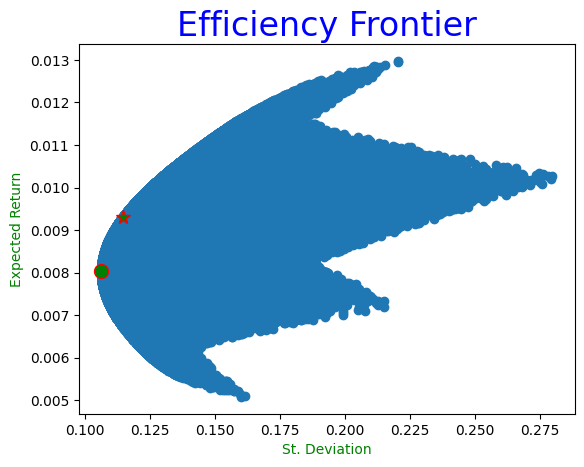

In [89]:
plt.title("Efficiency Frontier", fontsize=24, color='blue')
plt.xlabel("St. Deviation", fontsize=10, color='green')
plt.ylabel("Expected Return", fontsize=10, color='green')

plt.scatter(portfolio_dev, portfolio_return)

# Indicate the optimal and minimum risk portfolios
plt.plot(optimal_sd, optimal_ret, marker='*', markersize=10, markeredgecolor="red", markerfacecolor="green")
plt.plot(min_sd, min_ret, marker='o', markersize=10, markeredgecolor="red", markerfacecolor="green")

plt.show()

### Discover the values associated with the weights

In [90]:
# Establish the total amount invested
total_invested = 1000

In [94]:
# Display the rounded weights for each stock in the optimal portfolio
for i, stock in enumerate(stock_list):  
    amount = weights_opt[i] * total_invested
    print(f'{stock}: {amount.round(2)}')

AAPL: 364.8
NKE: 203.85
WMT: 258.9
META: 172.45


In [95]:
# Display the rounded weights for each stock in the min risk portfolio
for i, stock in enumerate(stock_list):  
    amount = weights_min[i] * total_invested
    print(f'{stock}: {amount.round(2)}')

AAPL: 226.22
NKE: 224.34
WMT: 414.93
META: 134.5
